# Experiment Motivation

Here we test GraphConv as the conv layers in the GNN model.

In [ ]:
args = {
    'num_layers': 3,
    'hidden_dim': 256,
    'output_dim': 256,
    'dropout': 0.3,
    'lr': 0.0001,
    'epochs': 10,
    'num_vocab': 5000,
    'warmup': 2,
    'weight_decay': 0.000001,
    'words_per_method_name': 5,
    'max_steps': 99999,
    'batch_size': 16,
    'heads': 3,
    'aggr': 'lstm',
}

# Setup

In [ ]:
!pip install ogb
!pip install torch_geometric
!python -c "import ogb; print(ogb.__version__)"

1.3.6


In [ ]:
import os
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from torch_geometric.loader import DataLoader
import torch
import pandas as pd
import torch.nn.functional as F
from tqdm.notebook import tqdm
print(torch.__version__)

# The PyG built-in conv
from torch_geometric.nn import GraphConv

import torch_geometric.transforms as T
from torch_geometric.nn import global_add_pool, global_mean_pool
from numpy import float32

import copy
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: {}'.format(device))

import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch_geometric.utils import degree

2.1.0+cu118
Device: cuda


# Dataset

In [ ]:
dataset = PygGraphPropPredDataset(name = "ogbg-code2")
print(dataset)
evaluator = Evaluator(name='ogbg-code2')
'''
==== Expected input format of Evaluator for ogbg-code2
{'seq_ref': seq_ref, 'seq_pred': seq_pred}
- seq_ref: a list of lists of strings
- seq_pred: a list of lists of strings
where seq_ref stores the reference sequences of sub-tokens, and
seq_pred stores the predicted sequences of sub-tokens.

==== Expected output format of Evaluator for ogbg-code2
{'F1': F1}
- F1 (float): F1 score averaged over samples.
'''

PygGraphPropPredDataset(452741)


"\n==== Expected input format of Evaluator for ogbg-code2\n{'seq_ref': seq_ref, 'seq_pred': seq_pred}\n- seq_ref: a list of lists of strings\n- seq_pred: a list of lists of strings\nwhere seq_ref stores the reference sequences of sub-tokens, and\nseq_pred stores the predicted sequences of sub-tokens.\n\n==== Expected output format of Evaluator for ogbg-code2\n{'F1': F1}\n- F1 (float): F1 score averaged over samples.\n"

In [ ]:
print(dataset.num_classes)
print(dataset.num_node_features)
print(dataset[0])
print(len(dataset.y))

-1
2
Data(edge_index=[2, 243], x=[244, 2], node_is_attributed=[244, 1], node_dfs_order=[244, 1], node_depth=[244, 1], y=[1], num_nodes=244)
452741


# GraphConv Model
This model uses multiple convolution layers and a global_add_pool pooling method for graph level aggregation.

In [ ]:
from torch_geometric.nn.models.tgn import Linear
class GraphConvModule(torch.nn.Module):
    """
    AST is a directed graph with 100-150 nodes. This GraphConv model takes in nodes of 2 dimension
    features and convert them to 1x256 embeddings using a basic encoder ASTNodeEncoder
    before passing the embedding through GraphConv layers. No self-loops are added to establish
    a baseline.

    Input
        Batch of node_size x256 dimensions
    Output
        Embeddings of batch_size x pred_list_len X num_classes, i.e. 64 x 5 x len(vocab_list)
    """
    def __init__(self, AST_emb, hidden_dim, output_dim, num_layers,
                 dropout, pred_list_len, num_classes, heads, aggr_type):
        super(GraphConvModule, self).__init__()

        self.AST_emb = AST_emb
        self.hidden_dim = hidden_dim
        self.pred_list_len = pred_list_len
        self.num_classes = num_classes
        self.heads = heads

        # conv layers
        self.convs = torch.nn.ModuleList()
        self.convs.extend([GraphConv(in_channels=hidden_dim, out_channels=hidden_dim) for i in range(num_layers-1)])
        self.convs.append(GraphConv(in_channels=hidden_dim, out_channels=output_dim))

        # Batch norm
        self.bns = torch.nn.ModuleList()
        self.bns.extend([torch.nn.BatchNorm1d(hidden_dim) for i in range(num_layers-1)])

        # Global pool
        self.pool_method = global_add_pool

        # Probability of an element getting zeroed
        self.dropout = dropout

        # Post-processing layer that transform graph embedding into 5 token
        # predictions for each graph
        self.post_mps = Linear(output_dim, num_classes*pred_list_len, bias=True)

        # self.post_mps = torch.nn.ModuleList()
        # for i in range(pred_list_len):
        #     self.post_mps.append(torch.nn.Linear(output_dim, self.num_classes))

        self.softmax = torch.nn.Softmax(dim=-1)

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, batched_data):
        x, edge_index, edge_attr, node_depth, batch = batched_data.x, batched_data.edge_index, batched_data.edge_attr, batched_data.node_depth, batched_data.batch

        # Pre-processing. Each node x has two features initially, the node type (e.g for , while)
        # and the node text (e.g. delete). ASTNodeEncoder is used to turn
        # 2 dimension into dim_hidden dimensions through a linear transformation

        # print("Raw x shape {}".format(x.shape)) # batch size * N x D

        x = self.AST_emb(x, node_depth.view(-1,))
        edge_index = edge_index[:, edge_index[1].argsort()]

        out = None
        for i in range(len(self.convs)-1):
            x = self.convs[i](x, edge_index)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        out = self.convs[-1](x, edge_index) # batch * N x outdim

        # Biased pooling based on the depth of the node.
        out = out * (0.5**node_depth)

        out = self.pool_method(out, batch) # batch x outdim
        #print("Output before pooling {}".format(out.shape))

        # We want to turn one single graph embedding per graph to pred 5
        # words. So the desired output is batch_size x word len x num_classes
        out = self.post_mps(out).view(out.shape[0], self.pred_list_len, self.num_classes) # batch_size x word_len x num_classes

        # pred_list = []
        # for i in range(self.pred_list_len):
        #     pred_list.append(self.post_mps[i](out))
        # out = torch.stack(pred_list, dim=1)

        #out = self.softmax(out)
        #print(out)

        return out

# Train

In [ ]:
def train(model, device, data_loader, optimizer, epoch, args):
    model.train()

    loss_accum = 0

    # Used to shorten training for debugging
    max_steps = args['max_steps']

    loss_fn = torch.nn.CrossEntropyLoss()

    for step, batch in enumerate(tqdm(data_loader, desc="Iteration")):
        batch = batch.to(device)

        if batch.x.shape[0] == 1 or batch.batch[-1] == 0:
            pass
        else:
            # if epoch < args['warmup']:
            #     iteration = epoch * len(data_loader) + step
            #     for param_group in optimizer.param_groups:
            #         param_group["lr"] = lr_modifier(iteration)

            # Each prediction is the one-hot probability of the classification
            pred_list = model(batch) # batch_size x words per graph x num_classes
            optimizer.zero_grad()

            # y comes in as a list of words per graph. Need to one-hot encode it
            y = one_hot_y(batch.y, args['num_classes'], args['words_per_method_name']) #batch_size x words_per_method_name x num_classes i.e. 32x5x15002

            # print("Pred_list {}".format(pred_list.shape))
            # print("One-hot encoded y shape {}".format(y.shape))

            #print("Batch y {}".format(batch.y[0]))

            # print("Pred_list {}".format(pred_list[0]))
            # print("One-hot encoded y {}".format(y[0]))

            loss = 0
            for i in range(pred_list.shape[0]):
                loss += loss_fn(pred_list[i].to(torch.float32), y[i].to(torch.float32))


            # pred_flat = pred_list.view(pred_list.shape[0]*args['words_per_method_name'],
            #                            args['num_classes']) # batch*word len x num_class
            # y_flat = y.view(y.shape[0]*args['words_per_method_name'],
            #                            args['num_classes']) # batch*word len x num_class

            #loss = loss_fn(pred_flat, y_flat.to(torch.float32))

            # print("Pred flat {}".format(pred_flat))
            # print("Y_flat {}".format(y_flat))

            loss_accum += loss/pred_list.shape[0]

            #print("Loss {}".format(loss.item()))

            loss.backward()
            optimizer.step()

            # Used to shorten training for debugging
            if step > max_steps:
                break

    print("Epoch loss {}".format(loss_accum / (step+1)))


# Eval

In [ ]:
def eval(model, device, loader, evaluator, args):
    model.eval()
    seq_ref_list = []
    seq_pred_list = []

    # Used to shorten training for debugging
    max_steps = args['max_steps']

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred_list = model(batch) # batch_size x pred_list_len X num_classes

            #print("Preds are {}".format(pred_list.shape))
            seq_ref_list.extend(batch.y)
            seq_pred_list.extend(decode_to_word(pred_list))

            #print("Seq_ref_list len {} pred list len {}".format(len(seq_ref_list), len(seq_pred_list)))

        # Used to shorten for debugging
        if step > max_steps:
            break

    print("seq_ref_list {}".format(seq_ref_list[:5]))
    print("seq_pred_list {}".format(seq_pred_list[:5]))

    input_dict = {"seq_ref": seq_ref_list, "seq_pred": seq_pred_list}

    return evaluator.eval(input_dict)

# Helper methods
Might modularize away in a different file

In [ ]:
class ASTNodeEncoder(torch.nn.Module):
    '''
        Input:
            x: default node feature. the first and second column represents node type and node attributes.
            depth: The depth of the node in the AST.

        Output:
            emb_dim-dimensional vector

    '''
    def __init__(self, emb_dim, num_nodetypes, num_nodeattributes, max_depth):
        super(ASTNodeEncoder, self).__init__()

        self.max_depth = max_depth

        self.type_encoder = torch.nn.Embedding(num_nodetypes, emb_dim)
        self.attribute_encoder = torch.nn.Embedding(num_nodeattributes, emb_dim)
        self.depth_encoder = torch.nn.Embedding(self.max_depth + 1, emb_dim)


    def forward(self, x, depth):
        depth[depth > self.max_depth] = self.max_depth
        return self.type_encoder(x[:,0]) + self.attribute_encoder(x[:,1]) + self.depth_encoder(depth)


def get_vocab_mapping(seq_list, num_vocab):
    '''
        Input:
            seq_list: a list of sequences
            num_vocab: vocabulary size
        Output:
            vocab2idx:
                A dictionary that maps vocabulary into integer index.
                Additioanlly, we also index '__UNK__' and '__EOS__'
                '__UNK__' : out-of-vocabulary term
                '__EOS__' : end-of-sentence
            idx2vocab:
                A list that maps idx to actual vocabulary.
    '''

    vocab_cnt = {}
    vocab_list = []
    for seq in seq_list:
        for w in seq:
            if w in vocab_cnt:
                vocab_cnt[w] += 1
            else:
                vocab_cnt[w] = 1
                vocab_list.append(w)

    cnt_list = np.array([vocab_cnt[w] for w in vocab_list])
    topvocab = np.argsort(-cnt_list, kind = 'stable')[:num_vocab]

    print('Coverage of top {} vocabulary:'.format(num_vocab))
    print(float(np.sum(cnt_list[topvocab]))/np.sum(cnt_list))

    vocab2idx = {vocab_list[vocab_idx]: idx for idx, vocab_idx in enumerate(topvocab)}
    idx2vocab = [vocab_list[vocab_idx] for vocab_idx in topvocab]

    # print(topvocab)
    # print([vocab_list[v] for v in topvocab[:10]])
    # print([vocab_list[v] for v in topvocab[-10:]])

    vocab2idx['__UNK__'] = num_vocab
    idx2vocab.append('__UNK__')

    vocab2idx['__EOS__'] = num_vocab + 1
    idx2vocab.append('__EOS__')

    # test the correspondence between vocab2idx and idx2vocab
    for idx, vocab in enumerate(idx2vocab):
        assert(idx == vocab2idx[vocab])

    # test that the idx of '__EOS__' is len(idx2vocab) - 1.
    # This fact will be used in decode_arr_to_seq, when finding __EOS__
    assert(vocab2idx['__EOS__'] == len(idx2vocab) - 1)

    return vocab2idx, idx2vocab

def one_hot_y(batch_y, num_classes, max_seq_len):
    '''
    Given data.y, produce a tensor batch_size x number of words per method name.

    Input:
        batch_data.y: a list of lists, each of word len. batch_size x word len
        output: one hot encoding of dimensions batch_size x word len x num_classes.
    '''
    #print(batch_y)
    labels = torch.zeros(len(batch_y), max_seq_len, dtype=torch.long).to(device)

    for i, y in enumerate(batch_y):
        # if the number of words in y is less than the max length, fill blanks with end of word token
        y = y[:max_seq_len] + ['__EOS__'] * max(0, max_seq_len - len(y))
        for j, w in enumerate(y):
            index = vocab2idx['__UNK__']
            if w in vocab2idx:
                index = vocab2idx[w]
            labels[i][j] = index
        # print(labels[i])
    labels_one_hot = F.one_hot(labels, num_classes).to(device) # batch x word len x num_class
    #print('labels {}'.format(labels_one_hot))

    return labels_one_hot

def decode_to_word(pred_list):
    '''
        The goal is to turn an one-hot-encoder back into word. We need to take the
        argmax of the prediction

        Input:  embeddings, batch x word len x num class
        Output: list of lists, each a sequence of words. batch x word len
    '''
    #print("Prediction {}".format(pred_list))
    argmax = torch.argmax(pred_list, dim=-1).tolist()
    #print("Argmax {}".format(argmax))

    for i, graph in enumerate(argmax):
        word_list = []
        for word_index in graph:
            if word_index < len(vocab2idx) - 2:
                w = idx2vocab[word_index]
                word_list.append(w)
        argmax[i] = word_list
    #print("decoded pred words {}".format(argmax))
    return argmax

#Run Epochs
Train and then evaluate the accuracy of the GCN model

In [ ]:
def run_epochs(model, evaluator, args, dataset):

    split_idx = dataset.get_idx_split()
    train_loader = DataLoader(dataset[split_idx["train"]], batch_size=args['batch_size'], shuffle=True)
    valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args['batch_size'], shuffle=False)
    test_loader = DataLoader(dataset[split_idx["test"]], batch_size=args['batch_size'], shuffle=False)

    valid_curve = []
    test_curve = []
    train_curve = []

    optimizer = torch.optim.AdamW(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

    # # We want to decrease lr as training goes progresses.
    # # lr_scheduler method decays lr with a cosine annealing according to https://arxiv.org/pdf/1608.03983.pdf
    # lr_modifier = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args['epochs'])
    # lr_steps = args['lr'] / (args['warmup'] * len(train_loader))
    # def lr_scheduler(s):
    #     lr = s * lr_steps
    #     return lr

    for epoch in range(1, args['epochs'] + 1):
        print("=====Epoch {}".format(epoch))
        print('Training...')
        train(model, device, train_loader, optimizer, epoch, args)

        print('Evaluating...')
        train_perf = eval(model, device, train_loader, evaluator, args)
        valid_perf = eval(model, device, valid_loader, evaluator, args)
        test_perf = eval(model, device, test_loader, evaluator, args)

        # if epoch >= args['warmup'] and lr_modifier is not None:
        #     lr_modifier.step()

        print({'Train': train_perf, 'Validation': valid_perf, 'Test': test_perf})

        train_curve.append(train_perf[dataset.eval_metric])
        valid_curve.append(valid_perf[dataset.eval_metric])
        test_curve.append(test_perf[dataset.eval_metric])

    print('F1')
    best_val_epoch = np.argmax(np.array(valid_curve))
    best_train = max(train_curve)
    print('Finished training!')
    print('Best validation score: {}'.format(valid_curve[best_val_epoch]))
    print('Test score: {}'.format(test_curve[best_val_epoch]))

    return valid_curve, test_curve, train_curve

In [ ]:
# There are 450k words (duplicates included) in the true labels.
# The top 15k is extracted and stored in a dict vocab2idx.
# This top 15k covers 96% of the all unique words.
vocab2idx, idx2vocab = get_vocab_mapping(dataset.y, args['num_vocab'])
print("Vocab list {}".format(vocab2idx))
args['num_classes'] = len(vocab2idx)

Coverage of top 5000 vocabulary:
0.901200162173439
Vocab list {'get': 0, 'to': 1, 'set': 2, 'create': 3, 'from': 4, 'add': 5, 'parse': 6, 'update': 7, 'list': 8, 'file': 9, 'check': 10, 'data': 11, 'is': 12, 'load': 13, 'read': 14, 'run': 15, 'by': 16, 'delete': 17, 'find': 18, 'write': 19, 'for': 20, 'name': 21, 'make': 22, 'remove': 23, 'dict': 24, 'all': 25, 'build': 26, 'config': 27, 'process': 28, 'path': 29, 'validate': 30, 'send': 31, 'on': 32, 'request': 33, 'save': 34, 'value': 35, 'type': 36, 'id': 37, 'generate': 38, 'info': 39, 'and': 40, 'user': 41, 'handle': 42, 'url': 43, 'init': 44, 'key': 45, 'string': 46, 'start': 47, 'with': 48, 'filter': 49, 'json': 50, 'convert': 51, 'query': 52, 'format': 53, 'main': 54, 'register': 55, 'plot': 56, 'in': 57, 'output': 58, 'event': 59, 'search': 60, 'model': 61, 'state': 62, 'message': 63, 'log': 64, 'index': 65, 'group': 66, 'table': 67, 'do': 68, 'extract': 69, 'as': 70, 'default': 71, 'text': 72, 'image': 73, 'object': 74, 'map'

# Main
Grab ogbg-code2 and create a dictionary of all of the y labels

In [ ]:
def main():
  nodetypes_mapping = pd.read_csv(os.path.join(dataset.root, 'mapping', 'typeidx2type.csv.gz'))
  nodeattributes_mapping = pd.read_csv(os.path.join(dataset.root, 'mapping', 'attridx2attr.csv.gz'))

  node_encoder = ASTNodeEncoder(args['hidden_dim'], num_nodetypes = len(nodetypes_mapping['type']), num_nodeattributes = len(nodeattributes_mapping['attr']), max_depth = 20)

  print(node_encoder)

  gnn = GraphConvModule(
      node_encoder,
      args['hidden_dim'],
      args['output_dim'],
      args['num_layers'],
      args['dropout'],
      args['words_per_method_name'],
      args['num_classes'],
      args['heads'],
      args['aggr']
  ).to(device)

  # param_size = 0
  # for param in gcn.parameters():
  #     param_size += param.nelement() * param.element_size()
  # print(param_size)

  return run_epochs(gnn, evaluator, args, dataset)

valid_curve = []
test_curve = []
train_curve = []

valid_curve, test_curve, train_curve = main()

ASTNodeEncoder(
  (type_encoder): Embedding(98, 256)
  (attribute_encoder): Embedding(10030, 256)
  (depth_encoder): Embedding(21, 256)
)
=====Epoch 1
Training...


Iteration:   0%|          | 0/25499 [00:00<?, ?it/s]

Epoch loss 3.163613796234131
Evaluating...


Iteration:   0%|          | 0/25499 [00:00<?, ?it/s]

seq_ref_list [['euclidean', 'dist'], ['compute', 'delaunay', 'triangulation'], ['current'], ['nl', 'connect'], ['get', 'vaults']]
seq_pred_list [[], ['get'], ['get'], ['get'], ['get']]


Iteration:   0%|          | 0/1427 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['plot', 'plot'], ['write'], [], [], []]


Iteration:   0%|          | 0/1372 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], ['add'], ['add']]
{'Train': {'precision': 0.1438248818557954, 'recall': 0.06038851009069847, 'F1': 0.08175146961161762}, 'Validation': {'precision': 0.12865699551503995, 'recall': 0.05366475219326164, 'F1': 0.07287861807299069}, 'Test': {'precision': 0.12610488427191544, 'recall': 0.05340509024215967, 'F1': 0.0724041851775586}}
=====Epoch 2
Training...


Iteration:   0%|          | 0/25499 [00:00<?, ?it/s]

Epoch loss 2.993013381958008
Evaluating...


Iteration:   0%|          | 0/25499 [00:00<?, ?it/s]

seq_ref_list [['printif'], ['get', 'sid'], ['validate', 'min'], ['switch'], ['from', 'job', 'graph']]
seq_pred_list [['set'], ['get'], ['set'], ['set'], ['from']]


Iteration:   0%|          | 0/1427 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [[], ['write', 'file'], [], [], []]


Iteration:   0%|          | 0/1372 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], [], ['add']]
{'Train': {'precision': 0.1539720473753358, 'recall': 0.06881572432487193, 'F1': 0.09079490985705546}, 'Validation': {'precision': 0.13549400300945202, 'recall': 0.0588572395547458, 'F1': 0.07848415724560703}, 'Test': {'precision': 0.13434025879351194, 'recall': 0.06069873669654971, 'F1': 0.08000273702159978}}
=====Epoch 3
Training...


Iteration:   0%|          | 0/25499 [00:00<?, ?it/s]

Epoch loss 2.911039113998413
Evaluating...


Iteration:   0%|          | 0/25499 [00:00<?, ?it/s]

seq_ref_list [['unmanaged', 'devices'], ['step'], ['set', 'currency'], ['all'], ['rescale', 'taps']]
seq_pred_list [['get'], ['close'], ['set'], ['get'], []]


Iteration:   0%|          | 0/1427 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['osm', 'plot', 'tt'], ['save', 'file', 'file'], [], [], []]


Iteration:   0%|          | 0/1372 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is', 'valid'], ['get'], ['get'], [], []]
{'Train': {'precision': 0.1715159715277369, 'recall': 0.08348441179342997, 'F1': 0.10600331221392953}, 'Validation': {'precision': 0.15183561964032666, 'recall': 0.07058471092634216, 'F1': 0.09107193055784017}, 'Test': {'precision': 0.1490530648198773, 'recall': 0.07217618989762238, 'F1': 0.09235607000779227}}
=====Epoch 4
Training...


Iteration:   0%|          | 0/25499 [00:00<?, ?it/s]

Epoch loss 2.8469579219818115
Evaluating...


Iteration:   0%|          | 0/25499 [00:00<?, ?it/s]

seq_ref_list [['update', 'endpoints'], ['get', 'likes'], ['validate'], ['quit'], ['register']]
seq_pred_list [[], ['get'], ['get'], ['close'], ['set']]


Iteration:   0%|          | 0/1427 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [[], ['save', 'file'], [], [], []]


Iteration:   0%|          | 0/1372 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], [], []]
{'Train': {'precision': 0.17122244935976627, 'recall': 0.08115725222393261, 'F1': 0.10467249375914976}, 'Validation': {'precision': 0.14748871455493712, 'recall': 0.06692491535481412, 'F1': 0.08770441598157774}, 'Test': {'precision': 0.14700656096227446, 'recall': 0.06940557190010443, 'F1': 0.08998983495292953}}
=====Epoch 5
Training...


Iteration:   0%|          | 0/25499 [00:00<?, ?it/s]

Epoch loss 2.797588348388672
Evaluating...


Iteration:   0%|          | 0/25499 [00:00<?, ?it/s]

seq_ref_list [['show', 'tree'], ['render', 'to', 'string'], ['qualify', 'map'], ['log', 'magnitude', 'spectrum'], ['create', 'relationship']]
seq_pred_list [['list'], ['render'], ['parse'], [], ['get', 'asset', 'form']]


Iteration:   0%|          | 0/1427 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['train'], ['save'], [], [], []]


Iteration:   0%|          | 0/1372 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], [], []]
{'Train': {'precision': 0.18567971318574292, 'recall': 0.09461130421260427, 'F1': 0.1185467240297415}, 'Validation': {'precision': 0.15908825291084133, 'recall': 0.0751959343875459, 'F1': 0.09661197275695238}, 'Test': {'precision': 0.16228509811068584, 'recall': 0.08043011475898298, 'F1': 0.10220351606354887}}
=====Epoch 6
Training...


Iteration:   0%|          | 0/25499 [00:00<?, ?it/s]

Epoch loss 2.7561352252960205
Evaluating...


Iteration:   0%|          | 0/25499 [00:00<?, ?it/s]

seq_ref_list [['coefficient', 'of', 'variation'], ['login'], ['search'], ['reconfigure', 'database'], ['valid', 'lock']]
seq_pred_list [[], ['add', 'user'], ['get'], ['set'], ['is']]


Iteration:   0%|          | 0/1427 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['train', 'losses', 'blobs', 'ds9'], ['save', 'file'], [], [], []]


Iteration:   0%|          | 0/1372 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], [], ['render']]
{'Train': {'precision': 0.19702984979508598, 'recall': 0.10524338935973446, 'F1': 0.12915152606749836}, 'Validation': {'precision': 0.16496398883873137, 'recall': 0.08144453001138804, 'F1': 0.10271022384578066}, 'Test': {'precision': 0.16765688597290568, 'recall': 0.08703815801273428, 'F1': 0.10837647610474291}}
=====Epoch 7
Training...


Iteration:   0%|          | 0/25499 [00:00<?, ?it/s]

Epoch loss 2.7193973064422607
Evaluating...


Iteration:   0%|          | 0/25499 [00:00<?, ?it/s]

seq_ref_list [['centroids'], ['attach'], ['names'], ['ensure', 'bytes'], ['matches', 'filters']]
seq_pred_list [['get'], ['add'], ['read'], ['to', 'json'], []]


Iteration:   0%|          | 0/1427 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['train'], ['save', 'file', 'file'], [], [], []]


Iteration:   0%|          | 0/1372 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], [], [], ['render']]
{'Train': {'precision': 0.20113013183782058, 'recall': 0.10874703414062348, 'F1': 0.13304174965938623}, 'Validation': {'precision': 0.16814874873997457, 'recall': 0.08391344938437019, 'F1': 0.10543875952343322}, 'Test': {'precision': 0.17042099507927827, 'recall': 0.09004407242515498, 'F1': 0.11143872858607687}}
=====Epoch 8
Training...


Iteration:   0%|          | 0/25499 [00:00<?, ?it/s]

Epoch loss 2.6897590160369873
Evaluating...


Iteration:   0%|          | 0/25499 [00:00<?, ?it/s]

seq_ref_list [['set', 'ruleaction'], ['prompt'], ['sim', 'one', 'period'], ['sync'], ['scatter']]
seq_pred_list [['set'], [], ['set'], ['set'], ['projected', 'valve', 'curve', 'prev', 'partition']]


Iteration:   0%|          | 0/1427 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['train', 'pool'], ['save', 'file', 'file'], [], [], []]


Iteration:   0%|          | 0/1372 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], [], ['render']]
{'Train': {'precision': 0.20607940172951353, 'recall': 0.1107630647938166, 'F1': 0.1356921490173125}, 'Validation': {'precision': 0.16721961695227244, 'recall': 0.08353203299405691, 'F1': 0.10463895524595881}, 'Test': {'precision': 0.17093888585140635, 'recall': 0.0897669021438841, 'F1': 0.11116159446531233}}
=====Epoch 9
Training...


Iteration:   0%|          | 0/25499 [00:00<?, ?it/s]

Epoch loss 2.6632463932037354
Evaluating...


Iteration:   0%|          | 0/25499 [00:00<?, ?it/s]

seq_ref_list [['from', 'shape'], ['frontogenesis'], ['set', 'connection', 'logging'], ['prepare', 'percolator', 'output'], ['post']]
seq_pred_list [[], [], ['get'], ['get'], ['send']]


Iteration:   0%|          | 0/1427 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['train'], ['save', 'file'], [], [], []]


Iteration:   0%|          | 0/1372 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], [], ['render']]
{'Train': {'precision': 0.21184979835415152, 'recall': 0.11302945332888266, 'F1': 0.13908381806478776}, 'Validation': {'precision': 0.17455333011935545, 'recall': 0.08710227893293152, 'F1': 0.10921747923325693}, 'Test': {'precision': 0.1754753660166454, 'recall': 0.09081331487701087, 'F1': 0.11338119866687389}}
=====Epoch 10
Training...


Iteration:   0%|          | 0/25499 [00:00<?, ?it/s]

Epoch loss 2.6415083408355713
Evaluating...


Iteration:   0%|          | 0/25499 [00:00<?, ?it/s]

seq_ref_list [['diag', 'ksl'], ['flush'], ['open'], ['normalize', 'coerce'], ['command']]
seq_pred_list [[], ['set'], [], ['validate'], []]


Iteration:   0%|          | 0/1427 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['train'], ['save'], [], [], []]


Iteration:   0%|          | 0/1372 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is', 'valid'], ['get'], ['get'], [], ['render']]
{'Train': {'precision': 0.21633935983162417, 'recall': 0.11777893756318955, 'F1': 0.14352686981264645}, 'Validation': {'precision': 0.1731567106397277, 'recall': 0.08700172038253293, 'F1': 0.10867012906062737}, 'Test': {'precision': 0.17339620922179697, 'recall': 0.09136732999499537, 'F1': 0.11300314057285078}}
F1
Finished training!
Best validation score: 0.10921747923325693
Test score: 0.11338119866687389


In [ ]:
print(train_curve)
print(valid_curve)
print(test_curve)

[0.08175146961161762, 0.09079490985705546, 0.10600331221392953, 0.10467249375914976, 0.1185467240297415, 0.12915152606749836, 0.13304174965938623, 0.1356921490173125, 0.13908381806478776, 0.14352686981264645]
[0.07287861807299069, 0.07848415724560703, 0.09107193055784017, 0.08770441598157774, 0.09661197275695238, 0.10271022384578066, 0.10543875952343322, 0.10463895524595881, 0.10921747923325693, 0.10867012906062737]
[0.0724041851775586, 0.08000273702159978, 0.09235607000779227, 0.08998983495292953, 0.10220351606354887, 0.10837647610474291, 0.11143872858607687, 0.11116159446531233, 0.11338119866687389, 0.11300314057285078]


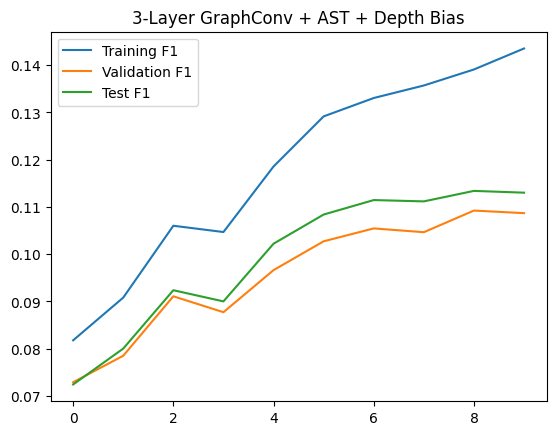

In [ ]:
from matplotlib import pyplot as plt

plt.title("3-Layer GraphConv + AST + Depth Bias")
plt.plot(train_curve, label="Training F1")
plt.plot(valid_curve, label="Validation F1")
plt.plot(test_curve, label="Test F1")
plt.legend()
plt.show()